In [96]:
import numpy as np
from pyecharts import Line,Scatter,Overlap,online
import matplotlib.pyplot as plt

In [8]:
# 加载数据
def loadDataSet():
    dataMat = []
    labelMat = []
    fr = open("./testSet.txt")
    for line in fr.readlines():
        lineArr = line.strip().split()
        dataMat.append([1.0]+[float(arr) for arr in lineArr[:-1]])
        labelMat.append(int(lineArr[-1]))
    return dataMat,labelMat

In [13]:
dataMat,labelMat = loadDataSet()

In [22]:
# 逻辑回归的 logistic function 还有好多
def sigmoid(inX):
    return 1.0/(1+np.exp(-inX)) # np.mat 对象 这里要使用np.exp

In [31]:
# 训练: 使用梯度上升寻找最佳回归系数weights
def gradientAscent(dataMat,classLabels):
    dataMatrix = np.mat(dataMat)
    labelMat = np.mat(classLabels).transpose()
    m,n = np.shape(dataMatrix)
    alpha = 0.001
    maxCycles = 500
    weights = np.ones((n,1))
    for k in range(maxCycles):
        h = sigmoid(dataMatrix*weights) # np.mat 对象将运算操作重载为矩阵运算
        error = labelMat - h
        weights = weights + alpha * dataMatrix.transpose()*error # 矩阵运算
    return weights

In [30]:
weights = gradientAscent(dataMat,labelMat)
weights

matrix([[ 4.12414349],
        [ 0.48007329],
        [-0.6168482 ]])

In [93]:
def plotBestFit(weights):
    dataMat,labelMat = loadDataSet()
    dataArr = np.array(dataMat)
    n = np.shape(dataArr)[0]
    xcord1 = []
    xcord2 = []
    ycord1 = []
    ycord2 = []
    for i in range(n):
        if int(labelMat[i]) == 1:
            xcord1.append(dataArr[i,1])
            ycord1.append(dataArr[i,2])
        else:
            xcord2.append(dataArr[i,1])
            ycord2.append(dataArr[i,2])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1,ycord1,s= 30,c = 'red',marker = 's')
    ax.scatter(xcord2,ycord2,s= 30,c = 'blue')
    x1 = np.arange(-3.0,3.0,0.1)
    x2 = -(weights[0]+ weights[1]*x1)/weights[2]
    ax.plot(x1,x2.getA1()) # 注意这里的维度问题 mat对象即使扁平化也是1*n维度的，getA1() 获得一个数组
    plt.xlabel("X1")
    plt.ylabel('X2')
    plt.show()

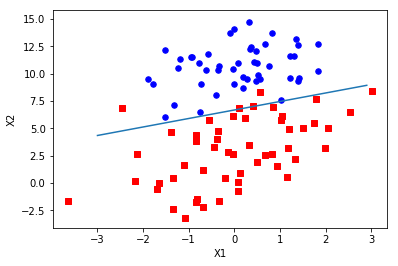

In [90]:
plotBestFit(weights)

In [138]:
def plotBestFit1(weights):
    dataMat,labelMat = loadDataSet()
    dataArr = np.array(dataMat)
    n = np.shape(dataArr)[0]
    xcord1 = []
    xcord2 = []
    ycord1 = []
    ycord2 = []
    for i in range(n):
        if int(labelMat[i]) == 1:
            xcord1.append(dataArr[i,1])
            ycord1.append(dataArr[i,2])
        else:
            xcord2.append(dataArr[i,1])
            ycord2.append(dataArr[i,2])
    x1 = np.arange(-3.0,3.0,0.1)
    x2 = -(weights[0]+ weights[1]*x1)/weights[2]
    online()
    scatter = Scatter("")
    scatter.add("1",xcord1,ycord1,is_stack = True)
    scatter.add("0",xcord2,ycord2,is_stack = True)
    scatter.add('Decision Boundary scatter',x1,x2.getA1(),is_stack = True)
    line = Line("")
    line.add('Decision Boundary line',x1,x2.getA1(),is_symbol_show  =False,is_stack = True)
    overlap = Overlap()
    overlap.add(scatter)
    overlap.add(line)
    return overlap

In [139]:
plotBestFit1(weights)